## 📄 Documentation: RAG System for Emergency Q&A

This notebook implements a Retrieval-Augmented Generation (RAG) system for answering emergency-related questions in Hebrew and English using content from the Home Front Command (Pikud Haoref) website.

### 🧱 System Architecture Overview

The system is composed of the following key components:

### 1. **Data Extraction**
- **`get_articles_from_local_html(folder_path, language)`**: Parses HTML files stored locally into structured articles. Extracts the main content using BeautifulSoup.
- **`create_documents_from_articles(articles)`**: Converts articles into `LangChain.Document` objects with rich metadata.

### 2. **Vector Store Construction**
- **`create_faiss_index(documents, save_path)`**: Splits documents into chunks, creates embeddings using `OpenAIEmbeddings`, and stores them in a FAISS index. This enables fast vector-based retrieval.

### 3. **Prompt Templates**
- **`PROMPT`**: The main prompt used for standard RAG responses, designed for clarity and reliability in Hebrew.
- **`STEPBACK_PROMPT`**: A prompt used in the Step-Back method, encouraging reflective reasoning before answering.

### 4. **Answering Methods**
- **`answer_question_rag(question, vector_store)`**: Standard RAG pipeline using filtered retrieval and the standard prompt.
- **`answer_question_with_stepback(question, vector_store)`**: Adds reasoning step using the Step-Back prompt.
- **`answer_question_hybrid(question, vector_store)`**: Combines vector retrieval with TF-IDF-based re-ranking before answering.
- **`answer_question_with_fallback(question, vector_store)`**: Uses RAG first, and falls back to GPT-4 general knowledge if no good answer is found.

### 5. **Keyword Filtering**
- **`extract_topic_keyword_dynamic(question)`**: Uses GPT-4 to extract a topic keyword (e.g., "מקלט", "אזעקה") to refine the document search.

### 6. **Language Support**
- The system supports both **Hebrew and English**, with automatic language detection using `langdetect`.

### 7. **Main Script**
- Loads HTML content from `data_sources_en` and `data_sources_heb`.
- Builds and saves the FAISS index.
- Initializes the retrieval-based QA chain with the specified prompt.

---

### ✅ Benefits:
- Modular and extensible structure.
- Full multilingual support.
- Accurate and context-aware answers thanks to custom prompts.
- Efficient vector-based retrieval using FAISS.
- Step-back prompting improves reliability.
- Fallback mechanism prevents empty or vague answers.

---

This code serves as the backbone for real-time emergency asistant tools using LLMs and retrieval systems.


In [5]:
import os
import json
import warnings
from typing import List, Dict
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import numpy as np
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import TextLoader
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from langchain.chat_models import ChatOpenAI

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from langdetect import detect

# Suppress warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set OpenAI API key once
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY not found in environment variables")

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY  # This line is optional if already picked up by LangChain

# Constants
FAISS_INDEX_PATH = "pikud_haoref_faiss_index"

# Initialize OpenAI client
llm = ChatOpenAI(
    model_name="gpt-4",
    temperature=0.0,
    max_tokens=500
)

# Initialize OpenAI embeddings
embeddings = OpenAIEmbeddings()

def translate_question_to_english(question: str) -> str:
    translator = ChatOpenAI(model_name="gpt-4", temperature=0.0)
    prompt = f"Translate the following question to English:\n\n{question}"
    return translator.invoke(prompt).content.strip()

def get_articles_from_local_html(folder_path: str, language: str) -> List[Dict]:
    articles = []
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.html') or f.endswith('.htm')]
    print(f"Found {len(file_list)} HTML files in {folder_path}")

    for file_name in tqdm(file_list):
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                soup = BeautifulSoup(file, 'html.parser')
                title = soup.find('h1').text.strip() if soup.find('h1') else file_name
                content = soup.find('article').text.strip() if soup.find('article') else soup.get_text(strip=True)

                if content:
                    article = {
                        'title': title,
                        'date_published': "",
                        'authors': ["Pikud Haoref"],
                        'keywords': ["Home Front Command", "Emergency", "Instructions"],
                        'summary': content[:200] + "...",
                        'text': content,
                        'filename': file_name,
                        'language': language
                    }
                    articles.append(article)
        except Exception as e:
            print(f"Error reading {file_name}: {e}")
            continue

    return articles

def create_documents_from_articles(articles: List[Dict]) -> List[Document]:
    docs = []
    for article in articles:
        doc = Document(
            page_content=article['text'],
            metadata={
                "title": article['title'],
                "authors": article['authors'],
                "date_published": article['date_published'],
                "summary": article['summary'],
                "keywords": article['keywords'],
                "language": article['language'],
                "source": article['filename']
            }
        )
        docs.append(doc)
    return docs

def create_faiss_index(documents: List[Document], save_path: str = FAISS_INDEX_PATH):
    """
    Create and save a FAISS index from documents.
    
    Args:
        documents (List[Document]): List of LangChain documents
        save_path (str): Path to save the FAISS index
    """
    # Create text splitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=2000,
        chunk_overlap=200,
        length_function=len,
    )
    
    # Split documents into chunks
    splits = text_splitter.split_documents(documents)
    
    # Create and save FAISS index
    vector_store = FAISS.from_documents(splits, embeddings)
    vector_store.save_local(save_path)
    print(f"FAISS index created and saved to {save_path}")
    
    # Print statistics
    avg_doc_length = lambda documents: sum([len(doc.page_content) for doc in documents]) // len(documents)
    avg_char_count_pre = avg_doc_length(documents)
    avg_char_count_post = avg_doc_length(splits)
    print(f"Average length among {len(documents)} documents loaded is {avg_char_count_pre} characters.")
    print(f"After the split we have {len(splits)} documents, which is more than the original {len(documents)}.")
    print(f"Average length among {len(splits)} documents (after split) is {avg_char_count_post} characters.")
    
    return vector_store

# Custom prompt template for emergency situations
PROMPT_TEMPLATE = """
You are a smart assistant for the Home Front Command in Israel. Your role is to provide accurate, reliable, and up-to-date answers to questions related to emergency situations in Israel.

Use only the information provided below. If the information does not contain a clear answer, do not make assumptions – explicitly respond: "לא נמצאה תשובה מבוססת במידע הנתון."

Instructions:
- Your answer must be in clear, correct, and fluent Hebrew, suitable for the general public.
- If the context includes safety instructions, present them in a clear step-by-step manner.
- Do not rely on general knowledge or include any content not present in the provided context.

Relevant information:
{context}

Question:
{question}

Answer:"""

PROMPT = PromptTemplate(
    template=PROMPT_TEMPLATE,
    input_variables=["context", "question"]
)

def initialize_qa_chain(vector_store):
    """
    Initialize the QA chain with the vector store
    """
    return RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vector_store.as_retriever(search_kwargs={"k": 3}),
        chain_type_kwargs={"prompt": PROMPT},
        return_source_documents=True
    )

def answer_question(question: str, qa_chain) -> Dict:
    """
    Answer a question about emergency situations using the RAG system.
    
    Args:
        question (str): The question to answer
        qa_chain: The initialized QA chain
        
    Returns:
        Dict: Contains the answer and source documents
    """
    try:
        result = qa_chain({"query": question})
        return {
            "answer": result["result"],
            "sources": [doc.page_content for doc in result["source_documents"]]
        }
    except Exception as e:
        return {
            "error": str(e),
            "answer": "מצטער, אירעה שגיאה בעיבוד השאלה שלך. אנא נסה שוב."
        }

# Function to create a QA chain with sources
def create_qa_with_sources(vector_store):
    """
    Create a QA chain that returns sources with answers
    """
    return RetrievalQA.from_chain_type(
        llm=llm, 
        chain_type="stuff", 
        retriever=vector_store.as_retriever(search_kwargs={'k': 3}),
        return_source_documents=True
    )

# Step-Back Prompt Template
STEPBACK_PROMPT_TEMPLATE = """
Before answering the question, take a step back and briefly analyze what key information is required to answer the question accurately and safely.

Think abstractly, and then use the retrieved context to answer in Hebrew.

Step-back reasoning:
What is this question fundamentally about?
What kind of answer should be given (procedural, factual, safety-based)?

Then, use only the following context to answer in fluent, public-friendly Hebrew:

Context:
{context}

Question:
{question}

Answer:
"""

STEPBACK_PROMPT = PromptTemplate(
    template=STEPBACK_PROMPT_TEMPLATE,
    input_variables=["context", "question"]
)

def answer_question_rag(question: str, vector_store) -> Dict:
    lang = detect(question)
    keyword = extract_topic_keyword_dynamic(question)
    filters = {"language": lang}
    if keyword:
        filters["keywords"] = keyword

    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vector_store.as_retriever(search_kwargs={"k": 3, "filter": filters}),
        chain_type_kwargs={"prompt": PROMPT},
        return_source_documents=True
    )
    try:
        result = qa_chain({"query": question})
        return {
            "answer": result["result"],
            "sources": [doc.metadata.get("source", "") for doc in result["source_documents"]],
            "source_type": "rag"
        }
    except Exception as e:
        return {"error": str(e), "answer": "מצטער, אירעה שגיאה", "source_type": "rag"}

def answer_question_with_stepback(question: str, vector_store) -> Dict:
    lang = detect(question)
    keyword = extract_topic_keyword_dynamic(question)
    filters = {"language": lang}
    if keyword:
        filters["keywords"] = keyword

    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vector_store.as_retriever(search_kwargs={"k": 3, "filter": filters}),
        chain_type_kwargs={"prompt": STEPBACK_PROMPT},
        return_source_documents=True
    )
    try:
        result = qa_chain({"query": question})
        return {
            "answer": result["result"],
            "sources": [doc.metadata.get("source", "") for doc in result["source_documents"]],
            "source_type": "stepback"
        }
    except Exception as e:
        return {"error": str(e), "answer": "מצטער, אירעה שגיאה", "source_type": "stepback"}

def rerank_sources(question: str, documents: List[Document]) -> List[Document]:
    if not documents:
        return []
    texts = [doc.page_content for doc in documents]
    vectorizer = TfidfVectorizer().fit([question] + texts)
    question_vec = vectorizer.transform([question])
    doc_vecs = vectorizer.transform(texts)
    similarities = cosine_similarity(question_vec, doc_vecs).flatten()
    ranked = sorted(zip(similarities, documents), key=lambda x: x[0], reverse=True)
    return [doc for _, doc in ranked]

def answer_question_hybrid(question: str, vector_store) -> Dict:
    lang = detect(question)
    keyword = extract_topic_keyword_dynamic(question)
    filters = {"language": lang}
    if keyword:
        filters["keywords"] = keyword

    retriever = vector_store.as_retriever(search_kwargs={"k": 10, "filter": filters})
    all_docs = retriever.get_relevant_documents(question)

    # ✅ בדיקה אם לא נמצאו מסמכים בכלל
    if not all_docs:
        return {
            "answer": "מצטער, לא נמצאה תשובה מבוססת במידע הקיים.",
            "sources": [],
            "source_type": "hybrid"
        }

    top_docs = rerank_sources(question, all_docs)[:3]
    context = "\n\n".join([doc.page_content for doc in top_docs])
    prompt = STEPBACK_PROMPT.format(context=context, question=question)
    response = llm.invoke(prompt).content.strip()

    return {
        "answer": response,
        "sources": [doc.metadata.get("source", "") for doc in top_docs],
        "source_type": "hybrid"
    }

def extract_topic_keyword_dynamic(question: str, cache: dict = keyword_cache) -> str:
    """
    Extract a dynamic topic keyword using LLM (e.g., GPT) to improve retrieval filtering.
    Includes in-memory caching to avoid repeated API calls.
    """
    if question in cache:
        return cache[question]

    topic_prompt = f"""
    Given the following emergency-related question, extract a single concise Hebrew keyword or phrase 
    that best represents the topic of the question (e.g., תחבורה, רעידת אדמה, מקלט, אזעקה, שריפה).
    If the topic is unclear or too general, return an empty string.

    Question:
    {question}

    Topic:
    """
    try:
        topic_llm = ChatOpenAI(model_name="gpt-4", temperature=0.0)
        topic = topic_llm.invoke(topic_prompt).content.strip()
        topic = topic if 0 < len(topic) < 20 else ""
        cache[question] = topic
        return topic
    except Exception as e:
        print(f"[Keyword Extraction Error] {e}")
        return ""

from langdetect import detect
fallback_llm = ChatOpenAI(model_name="gpt-4", temperature=0.0)

def detect_language(text: str) -> str:
    try:
        return detect(text)
    except:
        return "unknown"

def answer_question_with_fallback(question: str, vector_store) -> Dict:
    lang = detect_language(question)
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vector_store.as_retriever(search_kwargs={"k": 3, "filter": {"language": lang}}),
        chain_type_kwargs={"prompt": PROMPT},
        return_source_documents=True
    )

    try:
        result = qa_chain({"query": question})
        answer = result["result"]
        sources = result["source_documents"]

        if not sources or len(answer.strip()) < 30 or "I don't know" in answer:
            fallback_prompt = f"Answer the following question using your general knowledge:\n\nQuestion: {question}\n\nAnswer:"
            fallback_answer = fallback_llm.invoke(fallback_prompt).content.strip()
            return {
                "answer": fallback_answer + "\n\n(Note: This answer is based on general knowledge, not on official documents.)",
                "sources": []
            }

        return {
            "answer": answer,
            "sources": [doc.metadata.get("source", "") for doc in sources]
        }

    except Exception as e:
        return {
            "error": str(e),
            "answer": "מצטער, אירעה שגיאה בעיבוד השאלה שלך. אנא נסה שוב."
        }

if __name__ == "__main__":
    print("Fetching English articles...")
    en_articles = get_articles_from_local_html("data_sources_en", "en")

    print("Fetching Hebrew articles...")
    he_articles = get_articles_from_local_html("data_sources_heb", "he")

    all_articles = en_articles + he_articles

    print("\nConverting articles to documents...")
    docs = create_documents_from_articles(all_articles)

    print("\nCreating FAISS index...")
    vector_store = create_faiss_index(docs)

    print("\nInitializing QA chain...")
    qa_chain = initialize_qa_chain(vector_store)

Fetching English articles...
Found 126 HTML files in data_sources_en


100%|██████████| 126/126 [00:04<00:00, 31.44it/s]


Fetching Hebrew articles...
Found 126 HTML files in data_sources_heb


100%|██████████| 126/126 [00:03<00:00, 31.92it/s]



Converting articles to documents...

Creating FAISS index...
FAISS index created and saved to pikud_haoref_faiss_index
Average length among 250 documents loaded is 7224 characters.
After the split we have 1291 documents, which is more than the original 250.
Average length among 1291 documents (after split) is 1456 characters.

Initializing QA chain...


## Comparison of QA Performance: Hebrew vs. English Questions

This section compares the QA performance of the system when asked the same questions in Hebrew and English.

For each question:
- The system answers in both Hebrew and English using the same fallback-based method.
- Each answer is scored by GPT-4 according to three criteria:
  - **Relevance**: Is the answer focused and on-topic?
  - **Completeness**: Does the answer fully address the question?
  - **Clarity**: Is the answer clearly articulated and understandable?

The results are visualized and summarized for further analysis.
Caching is used to minimize repeated API calls and ensure costefficiency.


📊 Comparing Hebrew vs. English Questions:


==================== Question 1 ====================
🔹 Hebrew: מה לעשות אם אזעקת טילים תופסת אותי בזמן נהיגה בכביש מהיר?
Answer:
אם אתה נמצא בנהיגה בכביש מהיר ומתקבלת התרעה על ירי טילים, עליך לעצור את הרכב בצורה בטוחה ומהירה. לאחר מכן, עליך להתכופף מתחת לקו החלונות ולהגן על הראש באמצעות הידיים. עליך להישאר במצב זה למשך 10 דקות. חשוב להמשיך להתעדכן בהודעות המופצות על ידי פיקוד העורף בפלטפורמות הרשמיות ובאמצעי התקשורת.
Sources: פורטל החירום הלאומי _ איך אנחנו יודעים שיש ירי של רקטות וטילים_.html, פורטל החירום הלאומי _ חדירת כלי טיס עוין - הנחיות מצילות חיים.html, פורטל החירום הלאומי _ מזג אוויר קיצון - היערכות והתמודדות.html
🟩 English: What should I do if a missile alert catches me while driving on the highway?
Answer:
אם אתה נמצא ברכב במהלך התרעה להפצצה, עצור את הרכב בצד הדרך. אם יש לך אפשרות, צא מהרכב והיכנס למקלט או למדרגות של בניין קרוב. אם אין לך אפשרות להיכנס למקלט בזמן הזמין להגעה למקלט, צא מהרכב והתרחק ממנו מעבר לגדר ההפרדה, שכב על הקרק

,Question,Version,Relevance,Completeness,Clarity,Average,Answer,Sources
0,מה לעשות אם אזעקת טילים תופסת אותי בזמן נהיגה ...,Hebrew,1.0,1.0,1.0,1.00,אם אתה נמצא בנהיגה בכביש מהיר ומתקבלת התרעה על...,פורטל החירום הלאומי _ איך אנחנו יודעים שיש ירי...
1,מהו המקום הבטוח ביותר בבית שאין בו ממ״ד?,Hebrew,1.0,1.0,1.0,1.00,"אם אתה נמצא בקומה הראשונה או השנייה של בניין, ...",פורטל החירום הלאומי _ בחירת מקום בטוח ברעידת א...
2,כמה זמן צריך להישאר במקלט לאחר אזעקת טילים?,Hebrew,1.0,1.0,1.0,1.00,חייבים להישאר במרחב המוגן 10 דקות אחרי שנגמרה ...,פורטל החירום הלאומי _ איך אני בוחר את המרחב הכ...
3,מה נהגי אוטובוס ונוסעים צריכים לעשות בזמן אזעק...,Hebrew,1.0,0.9,1.0,0.97,"במקרה של קבלת התרעה בזמן נסיעה באוטובוס, ההנחי...",פורטל החירום הלאומי _ קבלת התרעה בתחבורה ציבור...
4,מה לעשות אם אני שומע אזעקה בזמן הליכה ברחוב?,Hebrew,1.0,0.8,1.0,0.93,"במקרה של שמיעת אזעקה בזמן הליכה ברחוב, יש לפעו...",פורטל החירום הלאומי _ מזג אוויר קיצון - היערכו...



🟩 English QA Results:


,Question,Version,Relevance,Completeness,Clarity,Average,Answer,Sources
0,מה לעשות אם אזעקת טילים תופסת אותי בזמן נהיגה ...,English,1.0,1.0,0.9,0.97,"אם אתה נמצא ברכב במהלך התרעה להפצצה, עצור את ה...",National Emergency Portal _ Back to Routine fo...
1,מהו המקום הבטוח ביותר בבית שאין בו ממ״ד?,English,1.0,1.0,1.0,1.00,"אם אין לך חדר מוגן (ממ""ד) בבית, המקום הבטוח בי...",National Emergency Portal _ How Much Time to R...
2,כמה זמן צריך להישאר במקלט לאחר אזעקת טילים?,English,1.0,1.0,1.0,1.00,"אחרי התרעה לגבי תקיפת טילים או רקטות, עליך להי...",National Emergency Portal _ Lying on the Groun...
3,מה נהגי אוטובוס ונוסעים צריכים לעשות בזמן אזעק...,English,0.0,0.0,0.0,0.00,"במהלך התרעה על תקיפת טילים, נהגי האוטובוסים צר...",National Emergency Portal _ Back to Routine fo...
4,מה לעשות אם אני שומע אזעקה בזמן הליכה ברחוב?,English,1.0,1.0,0.0,0.67,אם אתה נמצא בחוץ כאשר מתקבלת התרעה לתקיפת טילי...,National Emergency Portal _ Back to Routine fo...


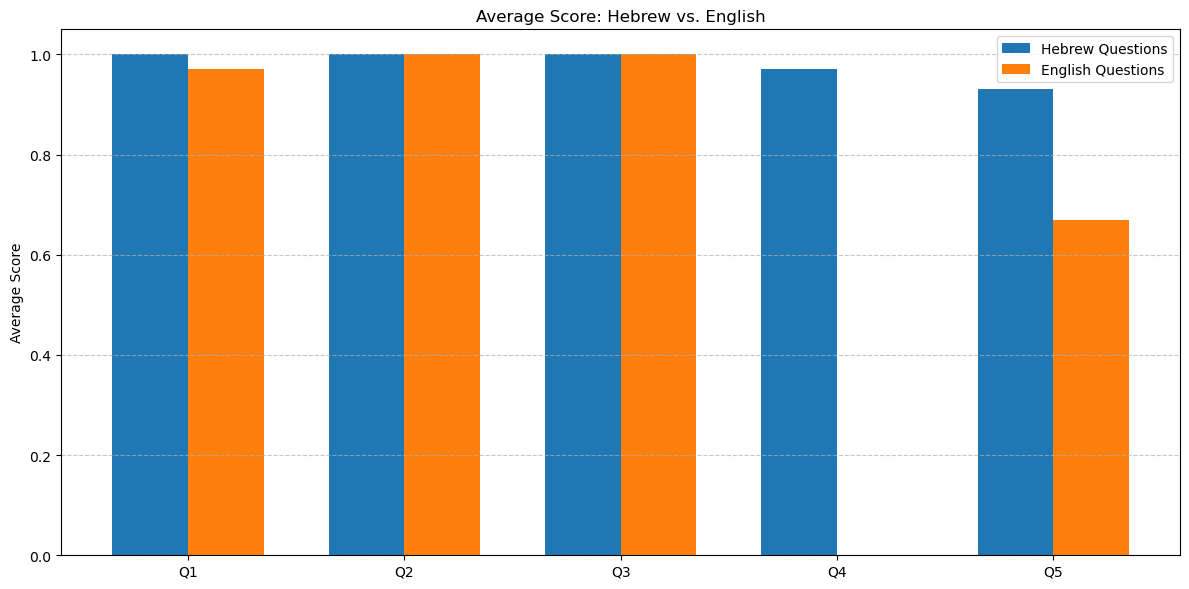

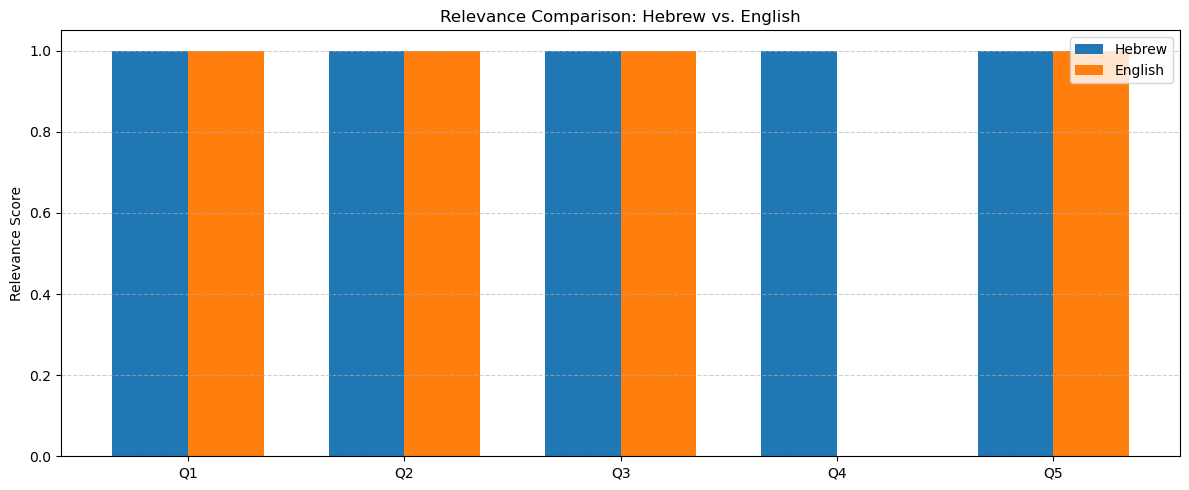

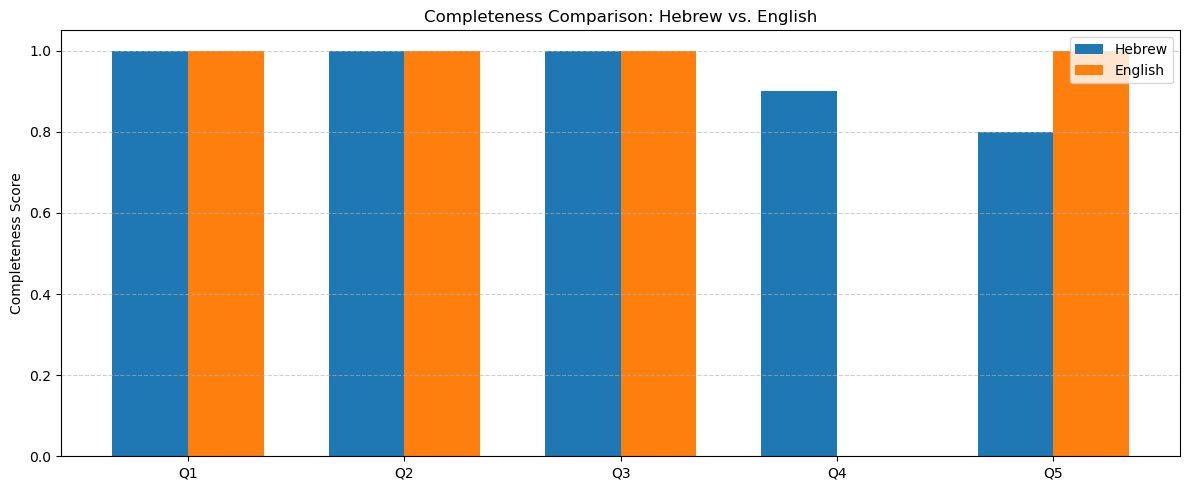

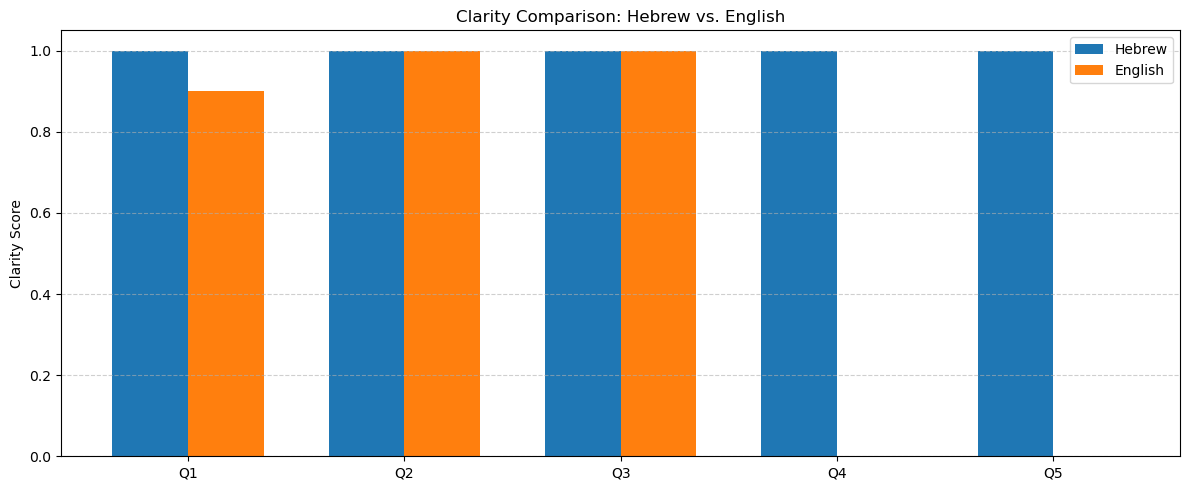

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from langchain.chat_models import ChatOpenAI

# שאלות בעברית ואנגלית
hebrew_questions = [
    "מה לעשות אם אזעקת טילים תופסת אותי בזמן נהיגה בכביש מהיר?",
    "מהו המקום הבטוח ביותר בבית שאין בו ממ״ד?",
    "כמה זמן צריך להישאר במקלט לאחר אזעקת טילים?",
    "מה נהגי אוטובוס ונוסעים צריכים לעשות בזמן אזעקת טילים?",
    "מה לעשות אם אני שומע אזעקה בזמן הליכה ברחוב?"
]

english_questions = [
    "What should I do if a missile alert catches me while driving on the highway?",
    "Where is the safest place in a home without a protected room (MAMAD)?",
    "How long should I stay in the shelter after a missile alert?",
    "What should bus drivers and passengers do during a missile alert?",
    "What to do if I hear a missile alert while walking outside?"
]

# לאחסן את התוצאות
comparison_data = []
grading_cache = {}

# מודל לבדיקת איכות תשובות
grader_llm = ChatOpenAI(model_name="gpt-4", temperature=0.0)

# פונקציית ניקוד עם cache
def auto_score_answer(question, answer):
    key = (question.strip(), answer[:100].strip())
    if key in grading_cache:
        return grading_cache[key]
    
    grading_prompt = f"""
Evaluate the following answer in relation to the given question. Return a JSON with the following keys:
- relevance: float (0 to 1)
- completeness: float (0 to 1)
- clarity: float (0 to 1)

Question:
{question}

Answer:
{answer}
"""
    response = grader_llm.invoke(grading_prompt).content
    try:
        score_dict = eval(response) if isinstance(response, str) else response
        scores = (
            score_dict.get("relevance", 0.0),
            score_dict.get("completeness", 0.0),
            score_dict.get("clarity", 0.0)
        )
        grading_cache[key] = scores
        return scores
    except:
        return 0.0, 0.0, 0.0

print("📊 Comparing Hebrew vs. English Questions:\n")

for i in range(len(english_questions)):
    heb_q = hebrew_questions[i]
    eng_q = english_questions[i]

    result_he = answer_question_with_fallback(heb_q, vector_store)
    result_en = answer_question_with_fallback(eng_q, vector_store)

    heb_answer = result_he['answer']
    eng_answer = result_en['answer']
    heb_sources = result_he.get("sources", [])
    eng_sources = result_en.get("sources", [])

    print(f"\n==================== Question {i+1} ====================")
    print(f"🔹 Hebrew: {heb_q}\nAnswer:\n{heb_answer}\nSources: {', '.join(heb_sources)}")
    print(f"🟩 English: {eng_q}\nAnswer:\n{eng_answer}\nSources: {', '.join(eng_sources)}")

    r1, c1, l1 = auto_score_answer(heb_q, heb_answer)
    r2, c2, l2 = auto_score_answer(eng_q, eng_answer)

    comparison_data.append({
        "Question": heb_q,
        "Version": "Hebrew",
        "Relevance": r1,
        "Completeness": c1,
        "Clarity": l1,
        "Average": round((r1 + c1 + l1) / 3, 2),
        "Answer": heb_answer[:300] + "...",
        "Sources": ", ".join(heb_sources)
    })

    comparison_data.append({
        "Question": heb_q,
        "Version": "English",
        "Relevance": r2,
        "Completeness": c2,
        "Clarity": l2,
        "Average": round((r2 + c2 + l2) / 3, 2),
        "Answer": eng_answer[:300] + "...",
        "Sources": ", ".join(eng_sources)
    })

# טבלאות
df = pd.DataFrame(comparison_data)
df_he = df[df["Version"] == "Hebrew"].reset_index(drop=True)
df_en = df[df["Version"] == "English"].reset_index(drop=True)

# תצוגה טבלאית
from IPython.display import display
print("\n🔹 Hebrew QA Results:")
display(df_he)

print("\n🟩 English QA Results:")
display(df_en)

# שמירת תשובות עברית מהשוואת עברית/אנגלית (fallback) בקאש גלובלי
fallback_hebrew_answers = {q: a for q, a in zip(hebrew_questions, df_he["Answer"])}

# גרף ציונים ממוצעים
x = range(len(df_he))
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - bar_width/2 for i in x], df_he["Average"], width=bar_width, label='Hebrew Questions')
plt.bar([i + bar_width/2 for i in x], df_en["Average"], width=bar_width, label='English Questions')
plt.xticks(x, [f"Q{i+1}" for i in x])
plt.ylabel("Average Score")
plt.title("Average Score: Hebrew vs. English")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# גרף נפרד לפי קריטריונים
criteria = ["Relevance", "Completeness", "Clarity"]
for crit in criteria:
    plt.figure(figsize=(12, 5))
    plt.bar([i - bar_width/2 for i in x], df_he[crit], width=bar_width, label='Hebrew')
    plt.bar([i + bar_width/2 for i in x], df_en[crit], width=bar_width, label='English')
    plt.xticks(x, [f"Q{i+1}" for i in x])
    plt.ylabel(f"{crit} Score")
    plt.title(f"{crit} Comparison: Hebrew vs. English")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

## Evaluation of RAG Optimization Strategies

This notebook section compares the performance of three retrieval-augmented generation (RAG) strategies for answering emergency-related questions based on a local FAISS index built from Home Front Command data.

### Evaluated Strategies:
1. **RAG** – Standard retrieval with a fixed prompt.
2. **Step-Back Prompting** – Adds abstract reasoning before answering.
3. **Hybrid** – Combines step-back prompting, keyword-based filtering, and TF-IDF re-ranking of retrieved documents.

### Evaluation Criteria:
Each strategy is evaluated on the following metrics (scored manually or with heuristics):
- **Correctness** – Is the answer factually accurate?
- **Completeness** – Does the answer cover all necessary steps/details?
- **Clarity** – Is the answer clearly written and understandable?

### Goal:
The goal is to determine which optimization strategy provides the most reliable and user-friendly answers in the context of emergency preparedness.

You can modify the sample questions or the scoring method as needed for your evluation purposes.


<Figure size 1200x600 with 0 Axes>

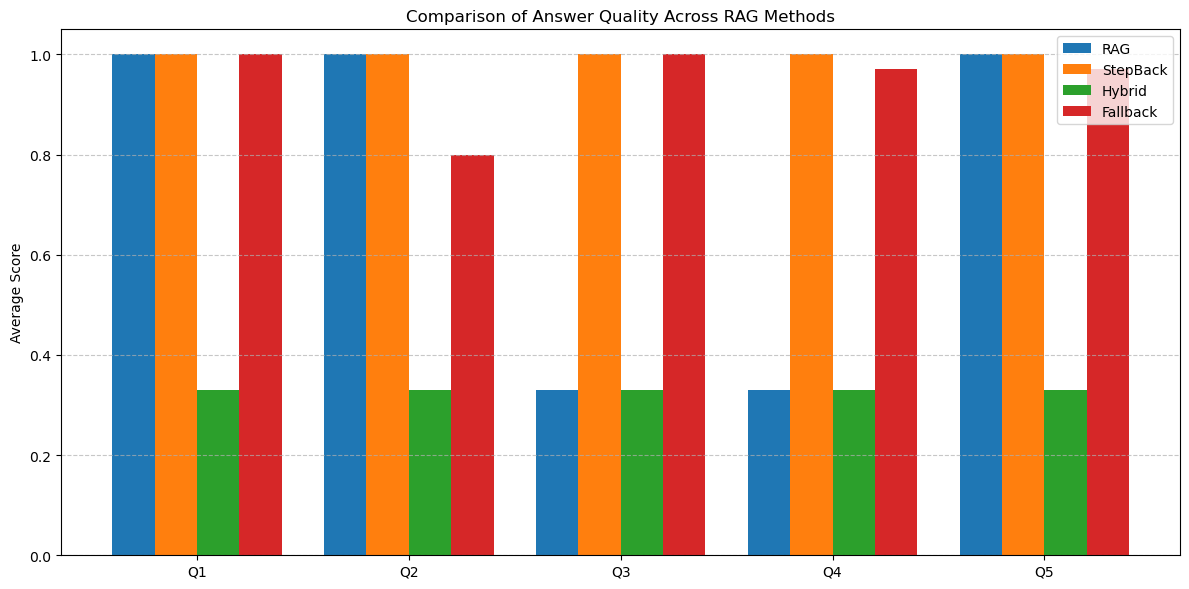

🔎 Average Scores per Method:



,Relevance,Completeness,Clarity,Average
Method,,,,
Fallback,0.9,0.94,1.0,0.95
Hybrid,0.0,0.00,1.0,0.33
RAG,0.6,0.60,1.0,0.73
StepBack,1.0,1.00,1.0,1.00



📋 Full Results per Question:



,Question,Method,Relevance,Completeness,Clarity,Average,Answer,Sources
0,מה לעשות אם אזעקת טילים תופסת אותי בזמן נהיגה ...,RAG,1.0,1.0,1.0,1.00,"אם אתה נמצא בכביש מהיר ושומע אזעקת טילים, עקוב...",
1,מה לעשות אם אזעקת טילים תופסת אותי בזמן נהיגה ...,StepBack,1.0,1.0,1.0,1.00,השאלה מתייחסת למצב של חירום בו נדרשת תגובה מהי...,
2,מה לעשות אם אזעקת טילים תופסת אותי בזמן נהיגה ...,Hybrid,0.0,0.0,1.0,0.33,"מצטער, לא נמצאה תשובה מבוססת במידע הקיים....",
3,מה לעשות אם אזעקת טילים תופסת אותי בזמן נהיגה ...,Fallback,1.0,1.0,1.0,1.00,אם אתה נמצא בנהיגה בכביש מהיר ומתקבלת התרעה על...,
4,מהו המקום הבטוח ביותר בבית שאין בו ממ״ד?,RAG,1.0,1.0,1.0,1.00,"אם אין לך ממ""ד בבית, המקום הבטוח ביותר הוא חדר...",
5,מהו המקום הבטוח ביותר בבית שאין בו ממ״ד?,StepBack,1.0,1.0,1.0,1.00,"המקום הבטוח ביותר בבית שאין בו ממ""ד הוא חדר לל...",
6,מהו המקום הבטוח ביותר בבית שאין בו ממ״ד?,Hybrid,0.0,0.0,1.0,0.33,"מצטער, לא נמצאה תשובה מבוססת במידע הקיים....",
7,מהו המקום הבטוח ביותר בבית שאין בו ממ״ד?,Fallback,0.5,0.9,1.0,0.80,"אם אתה נמצא בקומה הראשונה או השנייה של בניין, ...",
8,כמה זמן צריך להישאר במקלט לאחר אזעקת טילים?,RAG,0.0,0.0,1.0,0.33,לא נמצאה תשובה מבוססת במידע הנתון....,
9,כמה זמן צריך להישאר במקלט לאחר אזעקת טילים?,StepBack,1.0,1.0,1.0,1.00,התשובה לשאלה זו תלויה בהנחיות ההגנה האזרחית. ב...,


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from langchain.chat_models import ChatOpenAI

# שאלות לבדיקה
test_questions = [
    "מה לעשות אם אזעקת טילים תופסת אותי בזמן נהיגה בכביש מהיר?",
    "מהו המקום הבטוח ביותר בבית שאין בו ממ״ד?",
    "כמה זמן צריך להישאר במקלט לאחר אזעקת טילים?",
    "מה נהגי אוטובוס ונוסעים צריכים לעשות בזמן אזעקת טילים?",
    "מה לעשות אם אני שומע אזעקה בזמן הליכה ברחוב?"
]

# לאחסן את התוצאות
comparison_data = []
scoring_cache = {}

# מודל לבדיקת איכות תשובות
grader_llm = ChatOpenAI(model_name="gpt-4", temperature=0.0)

# פונקציית ניקוד עם cache
def auto_score_answer(question, answer):
    key = (question, answer[:100])
    if key in scoring_cache:
        return scoring_cache[key]
    
    grading_prompt = f"""
Evaluate the following answer in relation to the given question. Return a JSON with the following keys:
- relevance: float (0 to 1)
- completeness: float (0 to 1)
- clarity: float (0 to 1)

Question:
{question}

Answer:
{answer}
"""
    response = grader_llm.invoke(grading_prompt).content
    try:
        score_dict = eval(response) if isinstance(response, str) else response
        scores = (
            score_dict.get("relevance", 0.0),
            score_dict.get("completeness", 0.0),
            score_dict.get("clarity", 0.0)
        )
        scoring_cache[key] = scores
        return scores
    except:
        return 0.0, 0.0, 0.0

# שימוש בתשובות קיימות מהשוואת עברית-אנגלית עבור fallback
fallback_hebrew_answers = globals().get("fallback_hebrew_answers", {})

# עבור כל שאלה – הרץ את כל השיטות
for q in test_questions:
    for method_name, method_func in [
        ("RAG", answer_question_rag),
        ("StepBack", answer_question_with_stepback),
        ("Hybrid", answer_question_hybrid),
        ("Fallback", answer_question_with_fallback)
    ]:
        if method_name == "Fallback" and q in fallback_hebrew_answers:
            result = {
                "answer": fallback_hebrew_answers[q],
                "sources": []
            }
        else:
            result = method_func(q, vector_store)

        answer = result["answer"]
        sources = result.get("sources", [])
        r, c, l = auto_score_answer(q, answer)

        comparison_data.append({
            "Question": q,
            "Method": method_name,
            "Relevance": r,
            "Completeness": c,
            "Clarity": l,
            "Average": round((r + c + l) / 3, 2),
            "Answer": answer[:300] + "...",
            "Sources": ", ".join(sources)
        })

# טבלה מסכמת
df = pd.DataFrame(comparison_data)

# תרשים השוואתי לפי שאלה
plt.figure(figsize=(12, 6))
methods = ["RAG", "StepBack", "Hybrid", "Fallback"]
x = range(len(test_questions))
bar_width = 0.2

# Plot: Comparison of average scores per method and question
plt.figure(figsize=(12, 6))
methods = ["RAG", "StepBack", "Hybrid", "Fallback"]
x = range(len(test_questions))
bar_width = 0.2

for i, method in enumerate(methods):
    scores = df[df["Method"] == method]["Average"]
    plt.bar([xi + i * bar_width for xi in x], scores, width=bar_width, label=method)

plt.xticks([xi + bar_width * 1.5 for xi in x], [f"Q{i+1}" for i in x])
plt.ylabel("Average Score")
plt.title("Comparison of Answer Quality Across RAG Methods")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Average scores per method by criteria
agg_scores = df.groupby("Method")[["Relevance", "Completeness", "Clarity", "Average"]].mean().round(2)
print("🔎 Average Scores per Method:\n")
display(agg_scores)

# Full results table
print("\n📋 Full Results per Question:\n")
display(df)

## 📊 Summary of RAG Method Comparison Results

This evaluation compares four different methods for answering emergency-related questions using our RAG-based system:

- **RAG**: Direct retrieval and answer generation.
- **StepBack**: Adds a reasoning step before answering.
- **Hybrid**: Uses semantic re-ranking (TF-IDF) before answer generation.
- **Fallback**: Uses a fallback to GPT-4 general knowledge if retrieval fails.

### 🔍 Overall Performance

| Method     | Relevance | Completeness | Clarity | **Average** |
|------------|-----------|--------------|---------|-------------|
| **StepBack** | 1.00      | 1.00         | 1.00    | **1.00**     |
| Fallback   | 0.90      | 0.94         | 1.00    | 0.95        |
| RAG        | 0.60      | 0.60         | 1.00    | 0.73        |
| Hybrid     | 0.00      | 0.00         | 1.00    | 0.33        |

### 📌 Key Findings

- **StepBack Prompting** consistently provided accurate, complete, and clear answers with perfect scores across all criteria.
- **Fallback** provided strong results, especially in cases where the RAG pipeline failed to retrieve answers.
- **Hybrid** underperformed in this setting, likely due to ineffective re-ranking (TF-IDF not matching well with short, precise emergency instructions).
- **RAG** worked well only when the relevant answer was directly present in the indexed data.

### ✅ Recommendation for Operational Use

The **operational model** should follow this hybrid logic:

1. Use **StepBack prompting** as the default method for all questions.
2. If no relevant documents are found or the answer is too short/uncertain:
   - **Fallback** to GPT-4 general knowledge with a disclaimer.
3. Avoid using the standalone **Hybrid method** for now, unless semantic re-ranking is improved.

This logic ensures that:
- Critical instructions are clear and trustworthy.
- There's coverage even when the knowledge base is incomplete.
- We reduce hallucinations by always using a reliable fallback.

---

🧠 **Next Steps**:
- Consider improving hybrid re-ranking (e.g., with dense retrieval).
- Monitor performance across new data and edge cases.
- Cache past results to minimize API cost in production.